In [1]:
# import libraries 
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import pickle
from scipy.cluster import hierarchy
import math
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import Birch
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score, davies_bouldin_score

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.cluster import AgglomerativeClustering

In [2]:
my_colors = ['#88292F', '#697268', '#12355B', '#D7816A', '#e8da6f', '#c33b43', 
               '#9DBF9E', '#64a0e0', '#343934', '#280003','#cd5a61', '#913d27', 
               '#F46036', '#248232',  '#bea602', '#0a6682', '#646536', '#624763', '#2F1847', 
               '#FF7B9C', '#66A182', '#94849B', '#ACD8AA', '#F48498', '#B30089']
custom_cmap = LinearSegmentedColormap.from_list('custom_cmap', my_colors)

In [3]:
pca_df = pd.read_csv('pca_df.csv')
df_subset = pd.read_csv('df_subset.csv')

In [4]:
# Plot dendrogram
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [5]:
def clustering_score(estimator, X, silhouette_weight=0.5, davies_bouldin_weight=0.5):
    labels = estimator.fit_predict(X)
    silhouette = silhouette_score(X, labels)
    davies_bouldin = davies_bouldin_score(X, labels)
    final_score = silhouette_weight * silhouette + davies_bouldin_weight * davies_bouldin
    return final_score

single, avg, ward and centroid optimizations are by the NbClust function in the clusters.ipynb notebook

BIRCH uses the grid search to get the optimized parameters due to the lack of this method in the NbClust function

# Hierarchical clustering

## Aglomerative

### Single Link

Keeping number of defined clusters as none and test different distance threshold values:

In [6]:
# # Define the parameter grid
# param_grid = {
#     'distance_threshold': [0.01, 0.05, 0.1],
# }

# agg_clust = AgglomerativeClustering(linkage='single', n_clusters=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(agg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [7]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

keeping the distance threshold as none and testing different values for the numbers of clusters:

In [8]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 4, 6, 8, 10],
# }

# agg_clust = AgglomerativeClustering(linkage='single', distance_threshold=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(agg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [9]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Besides the silhouette score difference, the model will be fitted with the 0.01 distance threshold and then the dendrogram is going to be cut at the beggining to increase the silhouette score.

### Model with the parameters that offer the best silhouette score:

In [10]:
# Fit Agglomerative Clustering model on the combined data
model_single = AgglomerativeClustering(linkage= 'single',distance_threshold=None, n_clusters=2)
model_single.fit(np.array(pca_df))

AgglomerativeClustering(linkage='single')

In [11]:
with open('results/hierarchical_opt/single_clustering.pickle', 'wb') as f:
    pickle.dump(model_single, f)

In [12]:
with open('results/hierarchical_opt/single_clustering.pickle', 'rb') as f:
    model_single = pickle.load(f)

In [13]:
# hierarchy.set_link_color_palette(my_colors)

# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# # Plot the dendrogram
# plot_dendrogram(model_single, truncate_mode='level', p = 15)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [14]:
# # Cut dendrogram to obtain labels
# num_clusters = 2  # Adjust as needed

# # Convert the children_ attribute to a scipy hierarchical tree
# linkage_matrix = np.column_stack([model_single.children_, model_single.distances_,
#                                   np.ones_like(model_single.distances_)])
# # Cut the tree to obtain labels
# labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# print(labels_cut)

In [15]:
pca_df = pca_df.loc[:,:'PC2']

In [16]:
pca_df['cluster_label'] = model_single.labels_
pca_df['asset_id'] = df_subset['asset_id']

In [17]:
len(np.unique(model_single.labels_))

2

In [18]:
pca_df.to_csv('results/hierarchical_opt/csv_labels_cut_raw/single_link.csv', index = False)

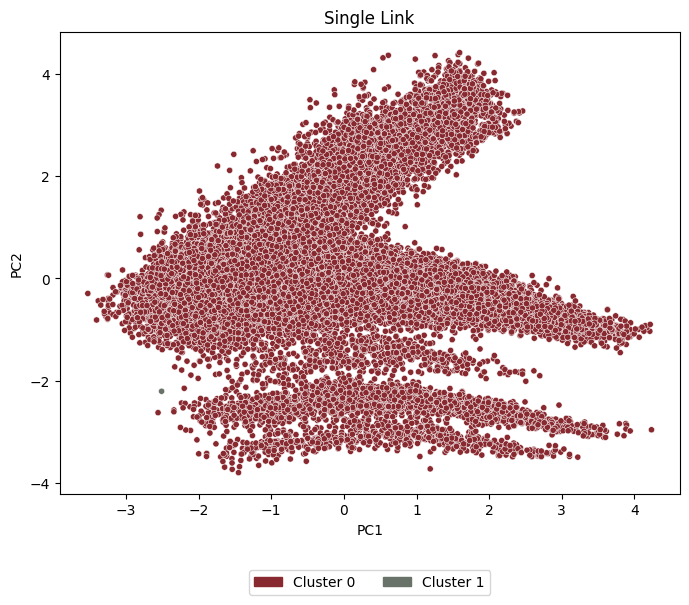

In [19]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Single Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(model_single.labels_)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [20]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,0
1,1.722822,-2.602608,11,0
2,1.451641,-2.588719,11,0
3,0.734407,-2.237956,11,0
4,0.121023,-2.182634,11,0


In [21]:
len(most_frequent_clusters.unique())

1

In [22]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,0
1,12,2.651199,-3.422293,0
2,13,1.451020,-0.049027,0
3,14,1.304045,-0.185737,0
4,15,2.222184,-0.592280,0
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,0
74,512,-0.236960,0.793759,0
75,513,1.510521,3.365319,0


In [23]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


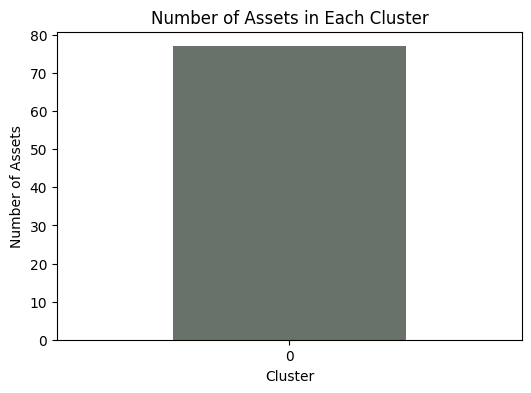

In [24]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [25]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/single_link.csv', index= False)

In [26]:
pca_df = pca_df.loc[:,:'PC2']

### Average Link

Keeping number of defined clusters as none and test different distance threshold values:

In [27]:
# # Define the parameter grid
# param_grid = {
#     'distance_threshold': [0.01, 0.05],
# }

# avg_clust = AgglomerativeClustering(linkage='average', n_clusters=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(avg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [28]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

keeping the distance threshold as none and testing different values for the numbers of clusters:

In [29]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 4, 6],
# }

# avg_clust = AgglomerativeClustering(linkage='average', distance_threshold=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(avg_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [30]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

Besides the silhouette score difference, the model will be fitted with the 0.05 distance threshold and then the dendrogram is going to be cut at the beggining to increase the silhouette score.

In [31]:
model_average = AgglomerativeClustering(linkage='average', distance_threshold=None, n_clusters=4)
model_average.fit(np.array(pca_df))

AgglomerativeClustering(linkage='average', n_clusters=4)

In [32]:
average_labels = model_average.labels_

In [33]:
len(np.unique(average_labels))

4

In [34]:
with open('results/hierarchical_opt/average_clustering.pickle', 'wb') as f:
    pickle.dump(model_average, f)

In [35]:
with open('results/hierarchical_opt/average_clustering.pickle', 'rb') as f:
    model_average = pickle.load(f)

In [36]:
# hierarchy.set_link_color_palette(my_colors)

# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# # Plot the dendrogram
# plot_dendrogram(model_average, truncate_mode='level', p = 4)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

cutting according to the optimization and not the dendrogram

In [37]:
# # Cut dendrogram to obtain labels
# num_clusters = 2  # Adjust as needed

# # Convert the children_ attribute to a scipy hierarchical tree
# linkage_matrix = np.column_stack([model_average.children_, model_average.distances_,
#                                   np.ones_like(model_average.distances_)])
# # Cut the tree to obtain labels
# labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# print(labels_cut)

In [38]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = average_labels
pca_df['asset_id'] = df_subset['asset_id']

In [39]:
pca_df.to_csv('results/hierarchical_opt/csv_labels_cut_raw/average_link.csv', index=False)

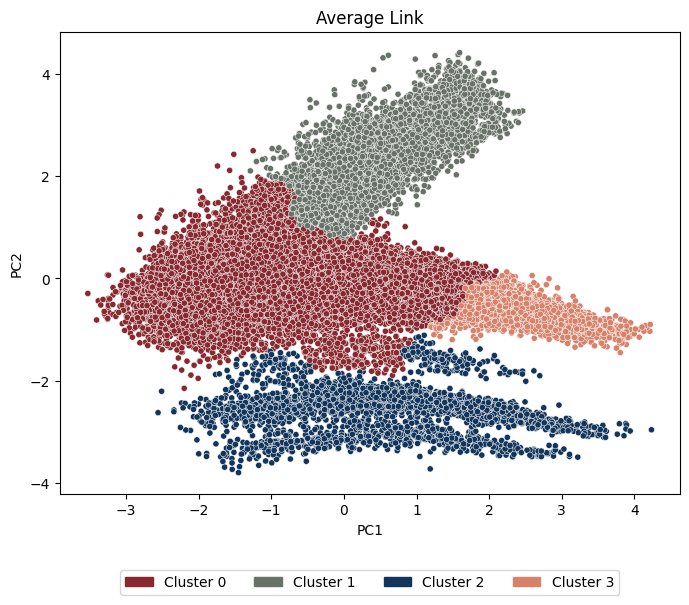

In [40]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title('Average Link')
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(average_labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [41]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,2
1,1.722822,-2.602608,11,2
2,1.451641,-2.588719,11,2
3,0.734407,-2.237956,11,2
4,0.121023,-2.182634,11,2


In [42]:
len(pca_df['cluster_label'].unique())

3

In [43]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,2
1,12,2.651199,-3.422293,2
2,13,1.451020,-0.049027,0
3,14,1.304045,-0.185737,0
4,15,2.222184,-0.592280,0
...,...,...,...,...
72,510,0.207552,2.331831,1
73,511,1.209865,3.228942,1
74,512,-0.236960,0.793759,1
75,513,1.510521,3.365319,1


In [44]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71]
Cluster 1: [36, 37, 38, 39, 40, 41, 42, 43, 44, 72, 73, 74, 75, 76]
Cluster 2: [0, 1, 52, 58]


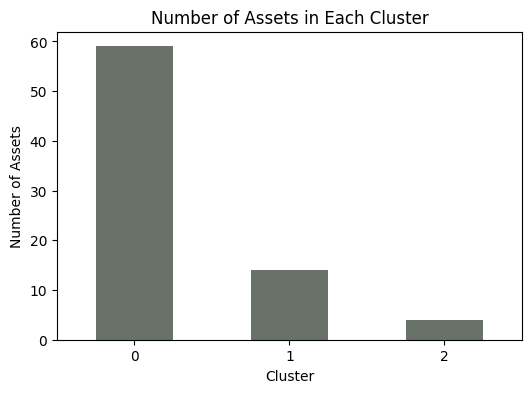

In [45]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [46]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/average_link.csv', index=False)

In [47]:
pca_df = pca_df.loc[:,:'PC2']

### Ward's method

In [48]:
# # Define the parameter grid
# param_grid = {
#     'distance_threshold': [0.01, 0.05, 0.1],
# }

# ward_clust = AgglomerativeClustering(linkage='ward', n_clusters=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(ward_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [49]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

keeping the distance threshold as none and testing different values for the numbers of clusters:

In [50]:
# # Define the parameter grid
# param_grid = {
#     'n_clusters': [2, 4, 6],
# }

# ward_clust = AgglomerativeClustering(linkage='ward', distance_threshold=None)

# # Initialize GridSearchCV
# grid_search = GridSearchCV(ward_clust, param_grid, scoring=silhouette_scorer, cv=2, verbose=2, n_jobs=-1)

# # Perform grid search
# grid_search.fit(pca_df)

In [51]:
# # Get the best parameters
# best_params = grid_search.best_params_
# print("Best Parameters:", best_params)

# # Get the best silhouette score
# best_score = grid_search.best_score_
# print("Best Silhouette Score:", best_score)

In [52]:
model_ward = AgglomerativeClustering(linkage='ward', distance_threshold=None, n_clusters=3)
model_ward.fit(np.array(pca_df))

AgglomerativeClustering(n_clusters=3)

In [53]:
# hierarchy.set_link_color_palette(my_colors)

# plt.figure(figsize=(12, 6))
# plt.title('Hierarchical Clustering Dendrogram')
# # Plot the dendrogram
# plot_dendrogram(model_ward, truncate_mode='level', p=5)
# plt.xlabel("Number of points in node (or index of point if no parenthesis).")
# plt.show()

In [54]:
with open('results/hierarchical_opt/ward_clustering.pickle', 'wb') as f:
    pickle.dump(model_ward,f)

In [55]:
with open('results/hierarchical_opt/ward_clustering.pickle', 'rb') as f:
    model_ward = pickle.load(f)

In [56]:
# # Cut dendrogram to obtain labels
# num_clusters = 2  # Adjust as needed

# # Convert the children_ attribute to a scipy hierarchical tree
# linkage_matrix = np.column_stack([model_ward.children_, model_ward.distances_,
#                                   np.ones_like(model_ward.distances_)])
# # Cut the tree to obtain labels
# labels_cut = fcluster(linkage_matrix, num_clusters, criterion='maxclust')

# print(labels_cut)

In [57]:
pca_df = pca_df.loc[:,:'PC2']

In [58]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = model_ward.labels_
pca_df['asset_id'] = df_subset['asset_id']

In [59]:
pca_df.to_csv('results/hierarchical_opt/csv_labels_cut_raw/ward_link.csv', index=False)

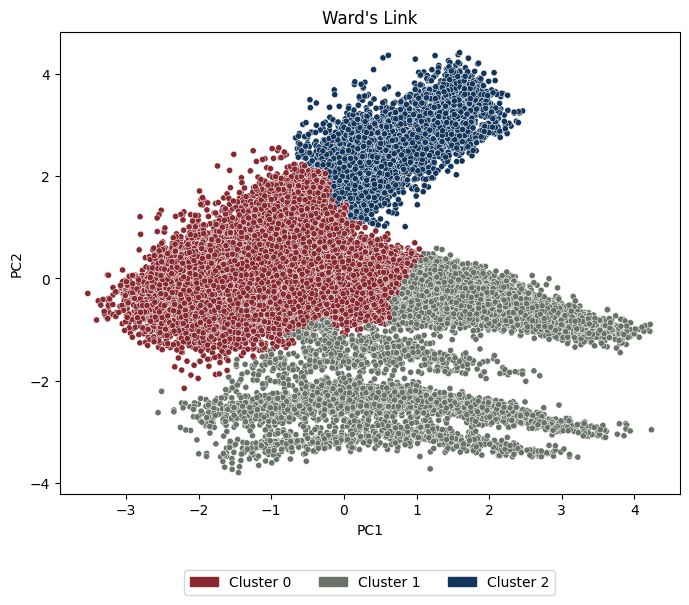

In [60]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("Ward's Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(model_ward.labels_)],
            loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [61]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,1
1,1.722822,-2.602608,11,1
2,1.451641,-2.588719,11,1
3,0.734407,-2.237956,11,1
4,0.121023,-2.182634,11,1


In [62]:
len(most_frequent_clusters.unique())

3

In [63]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,1
1,12,2.651199,-3.422293,1
2,13,1.451020,-0.049027,0
3,14,1.304045,-0.185737,0
4,15,2.222184,-0.592280,0
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,2
74,512,-0.236960,0.793759,2
75,513,1.510521,3.365319,0


In [64]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/ward_link.csv', index=False)

In [65]:
pca_df = pca_df.loc[:, 'PC1':'PC2']

In [66]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 55, 56, 57, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 75, 76]
Cluster 1: [0, 1, 33, 52, 58]
Cluster 2: [73, 74]


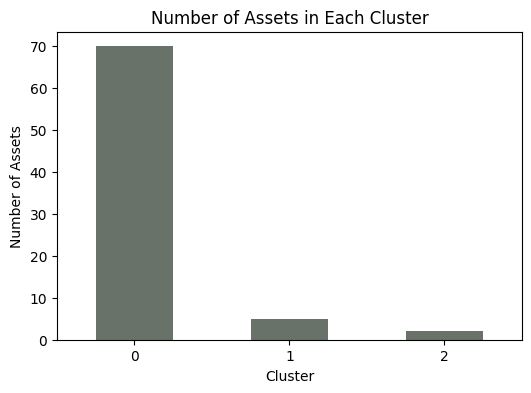

In [67]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### Centroid Linkage

In [68]:
pca_df = pca_df[['PC1', 'PC2']]

In [69]:
# Perform hierarchical clustering
model_centroid = linkage(pca_df, 'centroid')

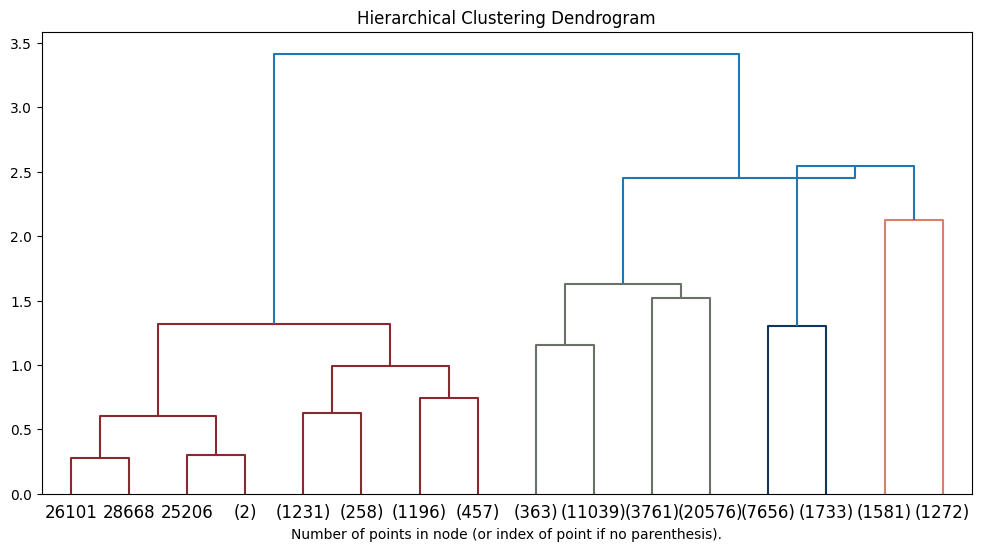

In [70]:
hierarchy.set_link_color_palette(my_colors)

plt.figure(figsize=(12, 6))
plt.title('Hierarchical Clustering Dendrogram')
# Plot the dendrogram
dendrogram(model_centroid, truncate_mode='level', p = 3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

In [71]:
with open('results/hierarchical_opt/centroid_clustering.pickle', 'wb') as f:
    pickle.dump(model_centroid,f)

In [72]:
with open('results/hierarchical_opt/centroid_clustering.pickle', 'rb') as f:
    model_centroid = pickle.load(f)

In [73]:
# Cut dendrogram to obtain labels
num_clusters = 2  # Adjust as needed

# Cut the tree to obtain labels
labels_cut = fcluster(model_centroid, num_clusters, criterion='maxclust')

print(labels_cut)

[2 2 2 ... 2 1 2]


In [74]:
pca_df = pca_df.loc[:,:'PC2']

In [75]:
# Assign the cluster labels to the original DataFrame
pca_df['cluster_label'] = labels_cut
pca_df['asset_id'] = df_subset['asset_id']

In [76]:
pca_df.to_csv('results/hierarchical_opt/csv_labels_cut_raw/centroid_link.csv', index=False)

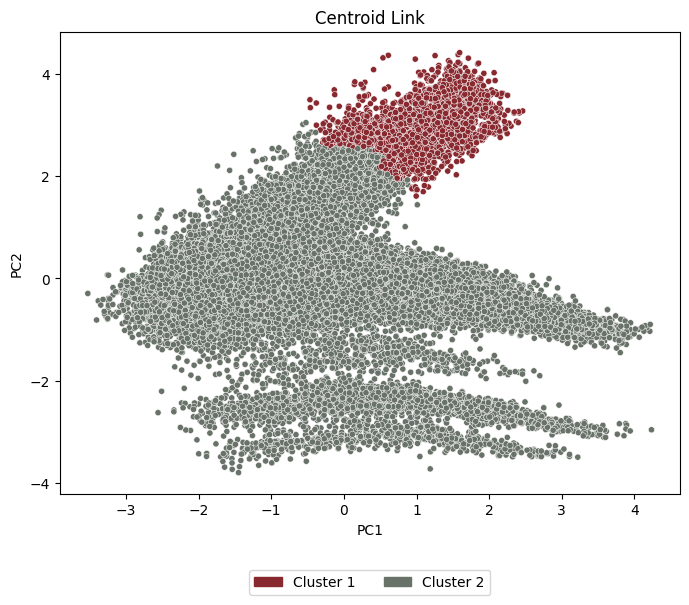

In [77]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("Centroid Link")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels_cut)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [78]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,2
1,1.722822,-2.602608,11,2
2,1.451641,-2.588719,11,2
3,0.734407,-2.237956,11,2
4,0.121023,-2.182634,11,2


In [79]:
len(most_frequent_clusters.unique())

1

In [80]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,2
1,12,2.651199,-3.422293,2
2,13,1.451020,-0.049027,2
3,14,1.304045,-0.185737,2
4,15,2.222184,-0.592280,2
...,...,...,...,...
72,510,0.207552,2.331831,2
73,511,1.209865,3.228942,2
74,512,-0.236960,0.793759,2
75,513,1.510521,3.365319,2


In [81]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/centroid_link.csv', index=False)

In [82]:
pca_df = pca_df.loc[:, :'PC2']

In [83]:
assets_clusters = representative_points.groupby('cluster_label')['asset_id']

# Print assets in each cluster
for cluster, assets in assets_clusters:
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 2: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76]


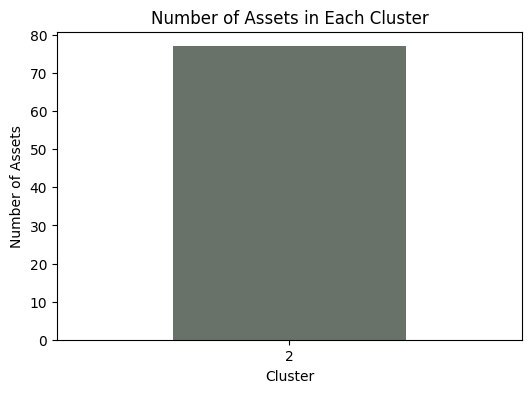

In [84]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = representative_points['cluster_label'].value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Cluster')
plt.ylabel('Number of Assets')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

### BIRCH

In [ ]:
# Define the parameter grid
param_grid = {
    'threshold': [0.5, 1, 1.5, 2],
    'n_clusters': [None, 2, 3, 5, 10],
}

birch_clust = Birch()

# Initialize GridSearchCV
grid_search = GridSearchCV(birch_clust, param_grid, scoring=clustering_score, cv=2, verbose=2, n_jobs=-1)

# Perform grid search
grid_search.fit(pca_df)

In [86]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_clusters,param_threshold,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
0,0.656439,0.064369,24.745569,1.721303,None,0.5,"{'n_clusters': None, 'threshold': 0.5}",0.624758,0.574975,0.599867,0.024891,7
1,0.799767,0.078721,24.919354,0.108079,None,1,"{'n_clusters': None, 'threshold': 1}",0.590292,0.565202,0.577747,0.012545,12
2,0.791507,0.076944,25.606677,0.098474,None,1.5,"{'n_clusters': None, 'threshold': 1.5}",0.633820,0.563821,0.598820,0.034999,8
3,0.776538,0.091635,13.628766,12.881219,None,2,"{'n_clusters': None, 'threshold': 2}",NaN,0.601686,NaN,NaN,16
4,1.115402,0.016177,24.575162,0.990478,2,0.5,"{'n_clusters': 2, 'threshold': 0.5}",0.715530,0.655853,0.685692,0.029838,1
5,0.669285,0.053895,25.367524,0.341410,2,1,"{'n_clusters': 2, 'threshold': 1}",0.701548,0.574603,0.638076,0.063473,3
6,0.751893,0.040253,24.218257,0.882411,2,1.5,"{'n_clusters': 2, 'threshold': 1.5}",0.704596,0.592908,0.648752,0.055844,2
7,0.566848,0.018479,12.736351,11.796546,2,2,"{'n_clusters': 2, 'threshold': 2}",NaN,0.601686,NaN,NaN,16
8,0.760424,0.032320,24.498378,1.264081,3,0.5,"{'n_clusters': 3, 'threshold': 0.5}",0.643599,0.598624,0.621112,0.022488,6
9,0.789999,0.028480,27.973595,2.641423,3,1,"{'n_clusters': 3, 'threshold': 1}",0.666693,0.586296,0.626494,0.040198,4


In [87]:
# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Get the best silhouette score
best_score = grid_search.best_score_
print("Best Clustering Score:", best_score)

Best Parameters: {'n_clusters': 2, 'threshold': 0.5}
Best Clustering Score: 0.6856915440919453


In [88]:
pca_df = pca_df[['PC1', 'PC2']]

In [89]:
brc = Birch(n_clusters=2, threshold=0.5)
brc.fit(pca_df)
labels = brc.predict(pca_df)
len(np.unique(labels))

2

In [90]:
with open('results/hierarchical_opt/birch.pickle', 'wb') as f:
    pickle.dump(brc, f)

In [91]:
pca_df = pca_df[['PC1', 'PC2']]

In [92]:
pca_df['cluster_label'] = labels 
pca_df['asset_id'] = df_subset['asset_id']
pca_df.head()

,PC1,PC2,cluster_label,asset_id
0,-1.163049,-2.596939,0,11
1,1.722822,-2.602608,1,11
2,1.451641,-2.588719,1,11
3,0.734407,-2.237956,1,11
4,0.121023,-2.182634,0,11


In [93]:
pca_df.to_csv('results/hierarchical_opt/csv_labels_cut_raw/birch.csv', index = False)

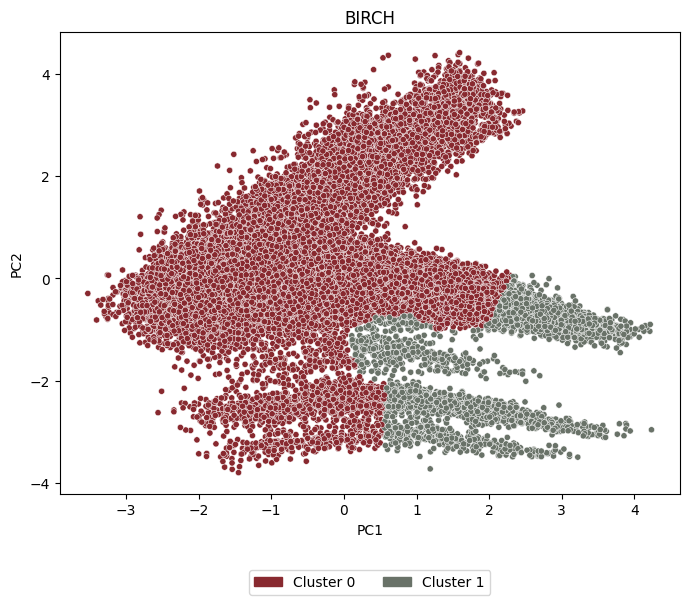

In [94]:
n_clusters = len(pca_df['cluster_label'].unique())
pallete = sns.color_palette(my_colors, n_clusters)

# Plot the representative points on a scatter plot using PCA results
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster_label', palette=pallete, s=20)
plt.title("BIRCH")
plt.xlabel('PC1')
plt.ylabel('PC2')
legend_handles = [mpatches.Circle((0, 0), radius=1, color=color) for color in my_colors]
plt.legend(handles=legend_handles, labels=[f'Cluster {cluster_label}' for cluster_label in np.unique(labels)],
           loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)
plt.show()

In [95]:
most_frequent_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Merge the most frequent cluster labels back to the original DataFrame
pca_df = pca_df.drop(columns='cluster_label')

pca_df = pd.merge(pca_df, most_frequent_clusters, on='asset_id', how='left')

pca_df.head()

,PC1,PC2,asset_id,cluster_label
0,-1.163049,-2.596939,11,1
1,1.722822,-2.602608,11,1
2,1.451641,-2.588719,11,1
3,0.734407,-2.237956,11,1
4,0.121023,-2.182634,11,1


In [96]:
len(most_frequent_clusters.unique())

2

In [97]:
representative_points = pca_df.groupby(['asset_id']).first().reset_index()
representative_points

,asset_id,PC1,PC2,cluster_label
0,11,-1.163049,-2.596939,1
1,12,2.651199,-3.422293,1
2,13,1.451020,-0.049027,0
3,14,1.304045,-0.185737,0
4,15,2.222184,-0.592280,0
...,...,...,...,...
72,510,0.207552,2.331831,0
73,511,1.209865,3.228942,0
74,512,-0.236960,0.793759,0
75,513,1.510521,3.365319,0


In [98]:
assets_clusters = pca_df.groupby('asset_id')['cluster_label'].agg(lambda x: np.bincount(x).argmax())

# Print assets in each cluster
for cluster, assets in assets_clusters.groupby(assets_clusters):
    print(f"Cluster {cluster}: {assets.index.tolist()}")

Cluster 0: [13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 36, 37, 38, 39, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 55, 56, 57, 58, 59, 110, 111, 112, 210, 211, 212, 213, 214, 215, 216, 217, 310, 311, 313, 314, 315, 316, 317, 410, 411, 412, 413, 414, 415, 416, 417, 510, 511, 512, 513, 514]
Cluster 1: [11, 12, 47, 312]


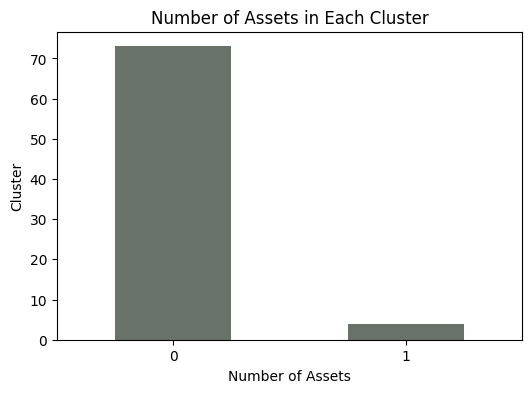

In [99]:
# Group assets by cluster and count the number of assets in each cluster
cluster_counts = assets_clusters.value_counts().sort_index()

# Plot the number of assets in each cluster
plt.figure(figsize=(6, 4))
cluster_counts.plot(kind='bar', color=my_colors[1])
plt.xlabel('Number of Assets')
plt.ylabel('Cluster')
plt.title('Number of Assets in Each Cluster')
plt.xticks(rotation=0)
plt.show()

In [100]:
pca_df.to_csv('results/hierarchical_opt/labels_most_common/birch.csv', index = False)